# CS 109a Final Project - Modeling
## Group 50

## 0. Import libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns
import math
%matplotlib inline
plt.style.use('ggplot')

## 1. Load Data

In [15]:
## Divide to train and test
data = pd.read_csv("data_model.csv",index_col=0)
data = data.drop('ABETA',1).drop('TAU',1).drop('PTAU',1)
data = data[np.isfinite(data['ADAS13_bl'])]
np.random.seed(9001)
msk = np.random.rand(len(data)) < 0.75
data_train = data[msk]
data_test = data[~msk]

X_train = data_train.drop('MCI_reversion_2y',1)
y_train = data_train['MCI_reversion_2y'].values
X_test = data_test.drop('MCI_reversion_2y',1)
y_test = data_test['MCI_reversion_2y'].values

## Normalization
attr_nums = ['AGE','RAVLT_immediate_bl','ADAS13_bl','CATANIMSC']
attr_cats = ['PTGENDER', 'PTMARRY', 'APOE4']

# Pre-process the categorical attributes
x_train = pd.get_dummies(X_train, columns=attr_cats, drop_first=True)
x_test = pd.get_dummies(X_test, columns=attr_cats, drop_first=True)

# Pre-process the numerical attributes
means = {attr_num: np.mean(x_train[attr_num]) for attr_num in attr_nums}
sds = {attr_num: np.std(x_train[attr_num], ddof=1) for attr_num in attr_nums}
for attr_num in attr_nums:
    x_train[attr_num] = (x_train[attr_num] - means[attr_num]) / sds[attr_num]
    x_test[attr_num] = (x_test[attr_num] - means[attr_num]) / sds[attr_num]

## 2. Classification Model

In [16]:
# TPR and FPR
def tpr(confusion_matrix):
    return confusion_matrix[1][1]/np.sum(confusion_matrix[1])
def fpr(confusion_matrix):
    return confusion_matrix[0][1]/np.sum(confusion_matrix[0])

 ### Logistic Regression

In [17]:
##  Logistic Regression 
logistic = LogisticRegressionCV(cv=5, penalty='l2').fit(x_train, y_train)
logistic_acc_train = logistic.score(x_train, y_train)
logistic_acc_test = logistic.score(x_test, y_test)
cm_log = metrics.confusion_matrix(y_train, logistic.predict(x_train))
auc_log= metrics.roc_auc_score(y_train, logistic.predict_proba(x_train)[:,1])

### Linear Discriminant Analysis

In [18]:
## Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis().fit(x_train, y_train)
lda_acc_train = lda.score(x_train, y_train)
lda_acc_test = lda.score(x_test, y_test)
cm_lda = metrics.confusion_matrix(y_train, lda.predict(x_train))
auc_lda= metrics.roc_auc_score(y_train, lda.predict_proba(x_train)[:,1])
auc_log_test= metrics.roc_auc_score(y_test, logistic.predict_proba(x_test)[:,1])
auc_lda_test= metrics.roc_auc_score(y_test, lda.predict_proba(x_test)[:,1])

### KNN

In [19]:
## KNN
neighbors = list(range(1,20))
cv_scores = []
# perform 5-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())
MSE = [1 - x for x in cv_scores]
### determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)
knn=KNeighborsClassifier(16).fit(x_train, y_train)
knn_acc_train = knn.score(x_train, y_train)
knn_acc_test = knn.score(x_test, y_test)
cm_knn = metrics.confusion_matrix(y_train, knn.predict(x_train))
auc_knn= metrics.roc_auc_score(y_train, knn.predict_proba(x_train)[:,1])
auc_knn_test= metrics.roc_auc_score(y_test, knn.predict_proba(x_test)[:,1])

The optimal number of neighbors is 6


### Decision Tree

In [20]:
## decision tree
### Use 5-fold cross-validation to choose the (maximum) depth for the tree
depths = range(2,25)
cv_scores_dt = []
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(dt, x_train, y_train, cv=5, scoring='accuracy')
    cv_scores_dt.append(scores.mean())
best_depth = depths[np.argmax(cv_scores_dt)]
print('The best maximum depth is %d'%(best_depth))

# Fit a decision tree model to the training set
dt = DecisionTreeClassifier(max_depth=best_depth)
dt.fit(x_train, y_train)

dt_acc_train = dt.score(x_train, y_train)
dt_acc_test = dt.score(x_test, y_test)
cm_dt = metrics.confusion_matrix(y_train, dt.predict(x_train))
auc_dt= metrics.roc_auc_score(y_train, dt.predict_proba(x_train)[:,1])
auc_dt_test= metrics.roc_auc_score(y_test, dt.predict_proba(x_test)[:,1])

The best maximum depth is 3


### Random Forest

In [21]:
##RF
### Fit random forest models to the training set for different number of trees
n_trees = 2**np.arange(1,9)
rf_acc_train = []
rf_acc_test = []
for n_tree in n_trees:
    rf = RandomForestClassifier(n_estimators=n_tree, max_features='sqrt', max_depth=best_depth)
    rf.fit(x_train, y_train)
    rf_acc_train.append(rf.score(x_train, y_train))
    rf_acc_test.append(rf.score(x_test, y_test))
df_rf = pd.DataFrame()
df_rf['Number of trees'] = n_trees
df_rf['Training accuracy'] = rf_acc_train
df_rf['Test accuracy'] = rf_acc_test
df_rf


,Number of trees,Training accuracy,Test accuracy
0,2,0.938462,0.928571
1,4,0.938462,0.946429
2,8,0.938462,0.946429
3,16,0.953846,0.946429
4,32,0.946154,0.946429
5,64,0.946154,0.946429
6,128,0.946154,0.946429
7,256,0.946154,0.946429


In [22]:
rf = RandomForestClassifier(n_estimators=8, max_features='sqrt', max_depth=best_depth)
rf.fit(x_train, y_train)
rf_acc_train = rf.score(x_train, y_train)
rf_acc_test = rf.score(x_test, y_test)
cm_rf = metrics.confusion_matrix(y_train, rf.predict(x_train))
auc_rf= metrics.roc_auc_score(y_train, rf.predict_proba(x_train)[:,1])
auc_rf_test= metrics.roc_auc_score(y_test, rf.predict_proba(x_test)[:,1])

### Boosting

In [23]:
## Boosting
n_tree = 2**np.arange(1,5)
depths = [1,2,10,None]
cv_scores_bo = {}
for depth in depths:
    for n in n_tree:
        adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), n_estimators=n, learning_rate=0.05)
        scores = cross_val_score(adaboost, x_train, y_train, cv=5, scoring='accuracy')
        cv_scores_bo[(depth,n)] = scores.mean()
best_depth, best_n_tree = max(cv_scores_bo, key=cv_scores_bo.get)
print('The optimal maximum depth is %d\nThe optimal number of trees is %d'%(best_depth, best_n_tree))
adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=best_depth), n_estimators=best_n_tree, learning_rate=0.05)
adaboost.fit(x_train, y_train)
adaboost_acc_train = adaboost.score(x_train, y_train)
adaboost_acc_test = adaboost.score(x_test, y_test)
cm_adaboost = metrics.confusion_matrix(y_train, adaboost.predict(x_train))
auc_adaboost= metrics.roc_auc_score(y_train, adaboost.predict_proba(x_train)[:,1])
auc_adaboost_test= metrics.roc_auc_score(y_test, adaboost.predict_proba(x_test)[:,1])

The optimal maximum depth is 2
The optimal number of trees is 16


### Model Performance

In [24]:
model = ['Logistic regression','LDA','k-NN','Decision Tree','Random Forest','Adaboost']
column = [ 'Training accuracy','Test accuracy','True postive rate','AUC_training','AUC_test']

models = pd.DataFrame(index=model, columns=column)
models['Training accuracy']=[logistic_acc_train, lda_acc_train,knn_acc_train,dt_acc_train,rf_acc_train,adaboost_acc_train]
models['Test accuracy']=[logistic_acc_test, lda_acc_test,knn_acc_test,dt_acc_test,rf_acc_test,adaboost_acc_test]
models['True postive rate']=[tpr(cm_log), tpr(cm_lda),tpr(cm_knn),tpr(cm_dt),tpr(cm_rf),tpr(cm_adaboost)]
models['AUC_training']=[auc_log, auc_lda,auc_knn,auc_dt,auc_rf,auc_adaboost]
models['AUC_test']=[auc_log_test, auc_lda_test,auc_knn_test,auc_dt_test,auc_rf_test,auc_adaboost_test]
models


,Training accuracy,Test accuracy,True postive rate,AUC_training,AUC_test
Logistic regression,0.923077,0.946429,0.0,0.898333,0.874214
LDA,0.930769,0.964286,0.3,0.935833,0.509434
k-NN,0.923077,0.946429,0.0,0.879583,0.735849
Decision Tree,0.953846,0.928571,0.4,0.920833,0.628931
Random Forest,0.938462,0.946429,0.4,0.966250,0.805031
Adaboost,0.969231,0.946429,0.6,0.990417,0.880503


### ROC curve for adaboost

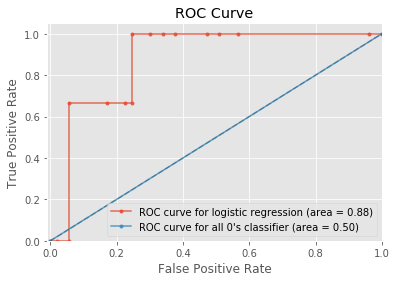

In [25]:
# Display the ROC curve for both the fitted classifier and the all 0's classifier on the test set. 
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, adaboost.predict_proba(x_test)[:,1])
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, np.zeros(len(y_test)))
auc1 = metrics.roc_auc_score(y_test, adaboost.predict_proba(x_test)[:,1])
auc2 = metrics.roc_auc_score(y_test, np.zeros(len(y_test)))
plt.plot(fpr1, tpr1, '.-', alpha=0.8, label='ROC curve for logistic regression (area = %0.2f)' % (auc1))
plt.plot(fpr2, tpr2, '.-', alpha=0.8, label='ROC curve for all 0\'s classifier (area = %0.2f)' % (auc2))
plt.plot([0, 1], [0, 1], 'k--', alpha=0.2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right");